In [13]:
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime
import os, fileinput,shutil
from pathlib import Path

Begin with changing a bit of data since the original datasets don't have headers (and CPU_temp is in millidegree Celsius)

Checking the NaN values of the combined dataset, I can see that there are 347 null values, which contribute a small portion of the whole dataset => I decide to delete or exclude any rows with empty cells.

In [2]:
csv_Files = [i for i in os.listdir() if i.find('.csv')!=-1]
header = ['Datetime', 'Temp', 'Humidity(%)', 'Atmospheric_pressure(Pa)', 'PM_1.0', 'PM_2.5', 'PM_10', 'CPU_temp']

In [ ]:
#clean data with \x00
for x in csv_Files:
    with fileinput.FileInput(x, inplace=True) as f:
        for line in f:
            print(line.replace('\x00', ''), end='')

In [ ]:
#transform data with 1991 year
def convertData1991(data):
    if data.year == 1991:
        return datetime.fromtimestamp(datetime.timestamp(data)+1000000000)
    else: 
        return data

try:
    for f in csv_Files:
        
        #read file
        df = pd.read_csv(f,header=None, index_col=False)

        #set header
        a = df.set_axis(header, axis=1)
            
        a['Datetime'] = pd.to_datetime(a['Datetime'])
        a.drop(a[a['Datetime'].dt.year == 1970].index, inplace=True)
        a['Datetime'] = a['Datetime'].map(convertData1991)

        #convert cpu temp to normal degree Celsius
        a['CPU_temp'] = a['CPU_temp'].map(lambda b: b/1000)

        a.to_csv(f'./workingdataset/{f[:len(f)-4]}f.csv', index=False)
except ValueError:
    pass

In [3]:
#Change to work directly with the formatted dataset
os.chdir('./workingdataset')
sourceFiles = [i for i in os.listdir() if i.find('.csv') != -1]

In [4]:
#transform the name of the file to the datetime format
def correctDate(name):
    x = name.find('_')
    y = name.find('.')

    realName = name[x+1:y-1]
    
    dateList = []
    dateList.append(realName[0:2])
    dateList.append(realName[2:4])
    dateList.append(f"20{realName[4:]}")

    a = '-'.join(dateList)
    d = datetime.strptime(a, "%d-%m-%Y")
    d.strftime("%Y-%m-%d")

    return d

#transform the date to get the name of the file
def findFileName(date, status):
    prefix = '2_'
    # if date > datetime.strptime('08-11-2022', "%d-%m-%Y"):
    #     prefix = '3_'
    if status == '3':
        prefix = '3_'
    
    day = str(date.day) if date.day>=10 else f'0{str(date.day)}'
    month = str(date.month)
    suffix = '22f.csv'

    return prefix + day + month + suffix

In [5]:
for f in sourceFiles:
    print(f'Reading {f}')
    df = pd.read_csv(f)
    converted_f = correctDate(f)
        
    #convert to datetime
    df['Datetime'] = pd.to_datetime(df['Datetime'])

    #compare to find the records with different date
    wrongData = df.loc[df['Datetime'].dt.date != converted_f.date()]
    print(f'Wrong data in {f}: {wrongData.shape}')

    #delete irrelevent rows in the first file
    checkedData = df.drop(wrongData.index)
    checkedData.to_csv(f, index=False)

    #get date of all wrong rows
    wrongDates = wrongData['Datetime'].dt.date.unique()
    converted_wrongDates = [str(i) for i in wrongDates]
    destinatedFiles = [datetime.strptime(x, "%Y-%m-%d") for x in converted_wrongDates]

    #access file with missing info
    for i in destinatedFiles:
        status = f[0]
        fileName = findFileName(i, status)
        mergeData = df.loc[df['Datetime'].dt.date == i.date()] 
        if fileName != '3_091122.csv' and fileName != '3_221222.csv':
            mergeFile = pd.read_csv(fileName)
            print(f'Other file ({fileName}): {mergeFile.shape}')

            concatenated = pd.concat([mergeData,mergeFile])
            print(f'Concatenated file: {concatenated.shape}')
            concatenated.to_csv(fileName, index=False)


Reading 2_151222f.csv
Wrong data in 2_151222f.csv: (0, 8)
Reading 2_161222f.csv
Wrong data in 2_161222f.csv: (0, 8)
Reading 2_171222f.csv
Wrong data in 2_171222f.csv: (0, 8)
Reading 2_181222f.csv
Wrong data in 2_181222f.csv: (0, 8)
Reading 3_151222f.csv
Wrong data in 3_151222f.csv: (0, 8)
Reading 3_161222f.csv
Wrong data in 3_161222f.csv: (0, 8)
Reading 3_171222f.csv
Wrong data in 3_171222f.csv: (0, 8)
Reading 3_181222f.csv
Wrong data in 3_181222f.csv: (0, 8)


In [ ]:
#detect NaN
for f in sourceFiles:
    df = pd.read_csv(f,header=None, index_col=False)
    df.set_axis(header, axis=1, copy=False)
    df['File'] = f
    
    a = df[df.isnull().any(axis=1)]
    a.to_csv('./nan_in_processed_file.csv',mode='a',header=None, index=False)

I notice some noticing factors in the dataset:
- Some files have the data of a few last minutes of the previous day. For example, the sheet 19/12 has 4 rows of data of 18/12 of the last minute of the day
- The datetime column currently has date and time, which makes the process harder to proceed => I need to separate them

I decide to take the mean of each hour and graph a histogram to see the changes of the PM amount each day and a line graph to demonstrate the changes through days.

In [6]:
#Combine all files
combinedFile = pd.concat(
    map(pd.read_csv, sourceFiles), ignore_index = True
)

combinedFile.to_csv('combined.csv', index=False)

In [ ]:
#separate data to their node folders
currPath = Path.cwd()

for i in sourceFiles:
    node = i[0]
    shutil.move(f'{currPath}/{i}',f'{currPath}/node_{node}/{i}')

In [ ]:
x = pd.read_csv('combined.csv')

x['Datetime'] = pd.to_datetime(x['Datetime'])
x['Date'] = x['Datetime'].dt.date
j = x.drop(x.loc[x['Date']<datetime(2022,12,1,0,0).date()].index)

j['PM_1.0_MA'] = j['PM_1.0'].rolling(window=60).mean()
j['PM_2.5_MA'] = j['PM_2.5'].rolling(window=60).mean()
j['PM_10_MA'] = j['PM_10'].rolling(window=60).mean()
j.dropna(inplace=True)
j.to_csv('check.csv')
j.sort_values('Datetime', inplace=True)

x_axis = j['Datetime']


plt.figure(figsize=(15,7))
plt.plot(x_axis, j['PM_1.0_MA'], label='PM_1.0')
plt.plot(x_axis, j['PM_2.5_MA'], label='PM_2.5')
plt.plot(x_axis, j['PM_10_MA'], label='PM_10')
plt.legend(loc='upper center')
plt.xlabel('hour')
plt.ylabel('µg/litter')
plt.title('All days')
plt.savefig('./graphs/all_days.pdf')

In [ ]:
#Plot all days data
x['Day'] = x['Datetime'].dt.day
combine_pm1 = x.groupby('Day')['PM_1.0'].mean()
combine_pm2_5 = x.groupby('Day')['PM_2.5'].mean()
combine_pm10 = x.groupby('Day')['PM_10'].mean()

a = list(i for i in x['Day'].unique() if i >= 15)
a.sort()

plt.figure(figsize=(10,7))
plt.plot(a, combine_pm1[3:], label='PM_1.0')
plt.plot(a, combine_pm2_5[3:], label='PM_2.5')
plt.plot(a, combine_pm10[3:], label='PM_10')
plt.legend(loc='upper center')
plt.xlabel('day')
plt.ylabel('µg/litter')

In [ ]:
# def meanDataInMinute(df):
#     df['Time'] = df['Datetime'].dt.time
#     df['Time'] = df['Time'].map(lambda x: x.replace(second=0))
#     df['Datetime'] = df['Datetime'].map(lambda x: x.replace(second=0))
#     f = df.groupby([df['Datetime'].dt.date, df['Time']])['PM_1.0'].mean()

#     return f

f = pd.read_csv('./node_2/2_161222f.csv')
f['Datetime'] = pd.to_datetime(f['Datetime'])
f['Datetimef'] = f['Datetime'].map(lambda x: x.replace(second=0))
f.sort_values(by='Datetime', inplace=True)

f['PM_1.0_MA'] = f['PM_1.0'].rolling(window=30).mean()
x = f['Datetime']
f['PM_1.0_MA'] = f['PM_1.0_MA'].fillna(f['PM_1.0_MA'][29])
j = f['PM_1.0_MA']

plt.figure(figsize=(14,7))
plt.plot(x,j, label='PM_1.0')
plt.legend(loc='upper center')
plt.xlabel('time')
plt.ylabel('µg/litter')

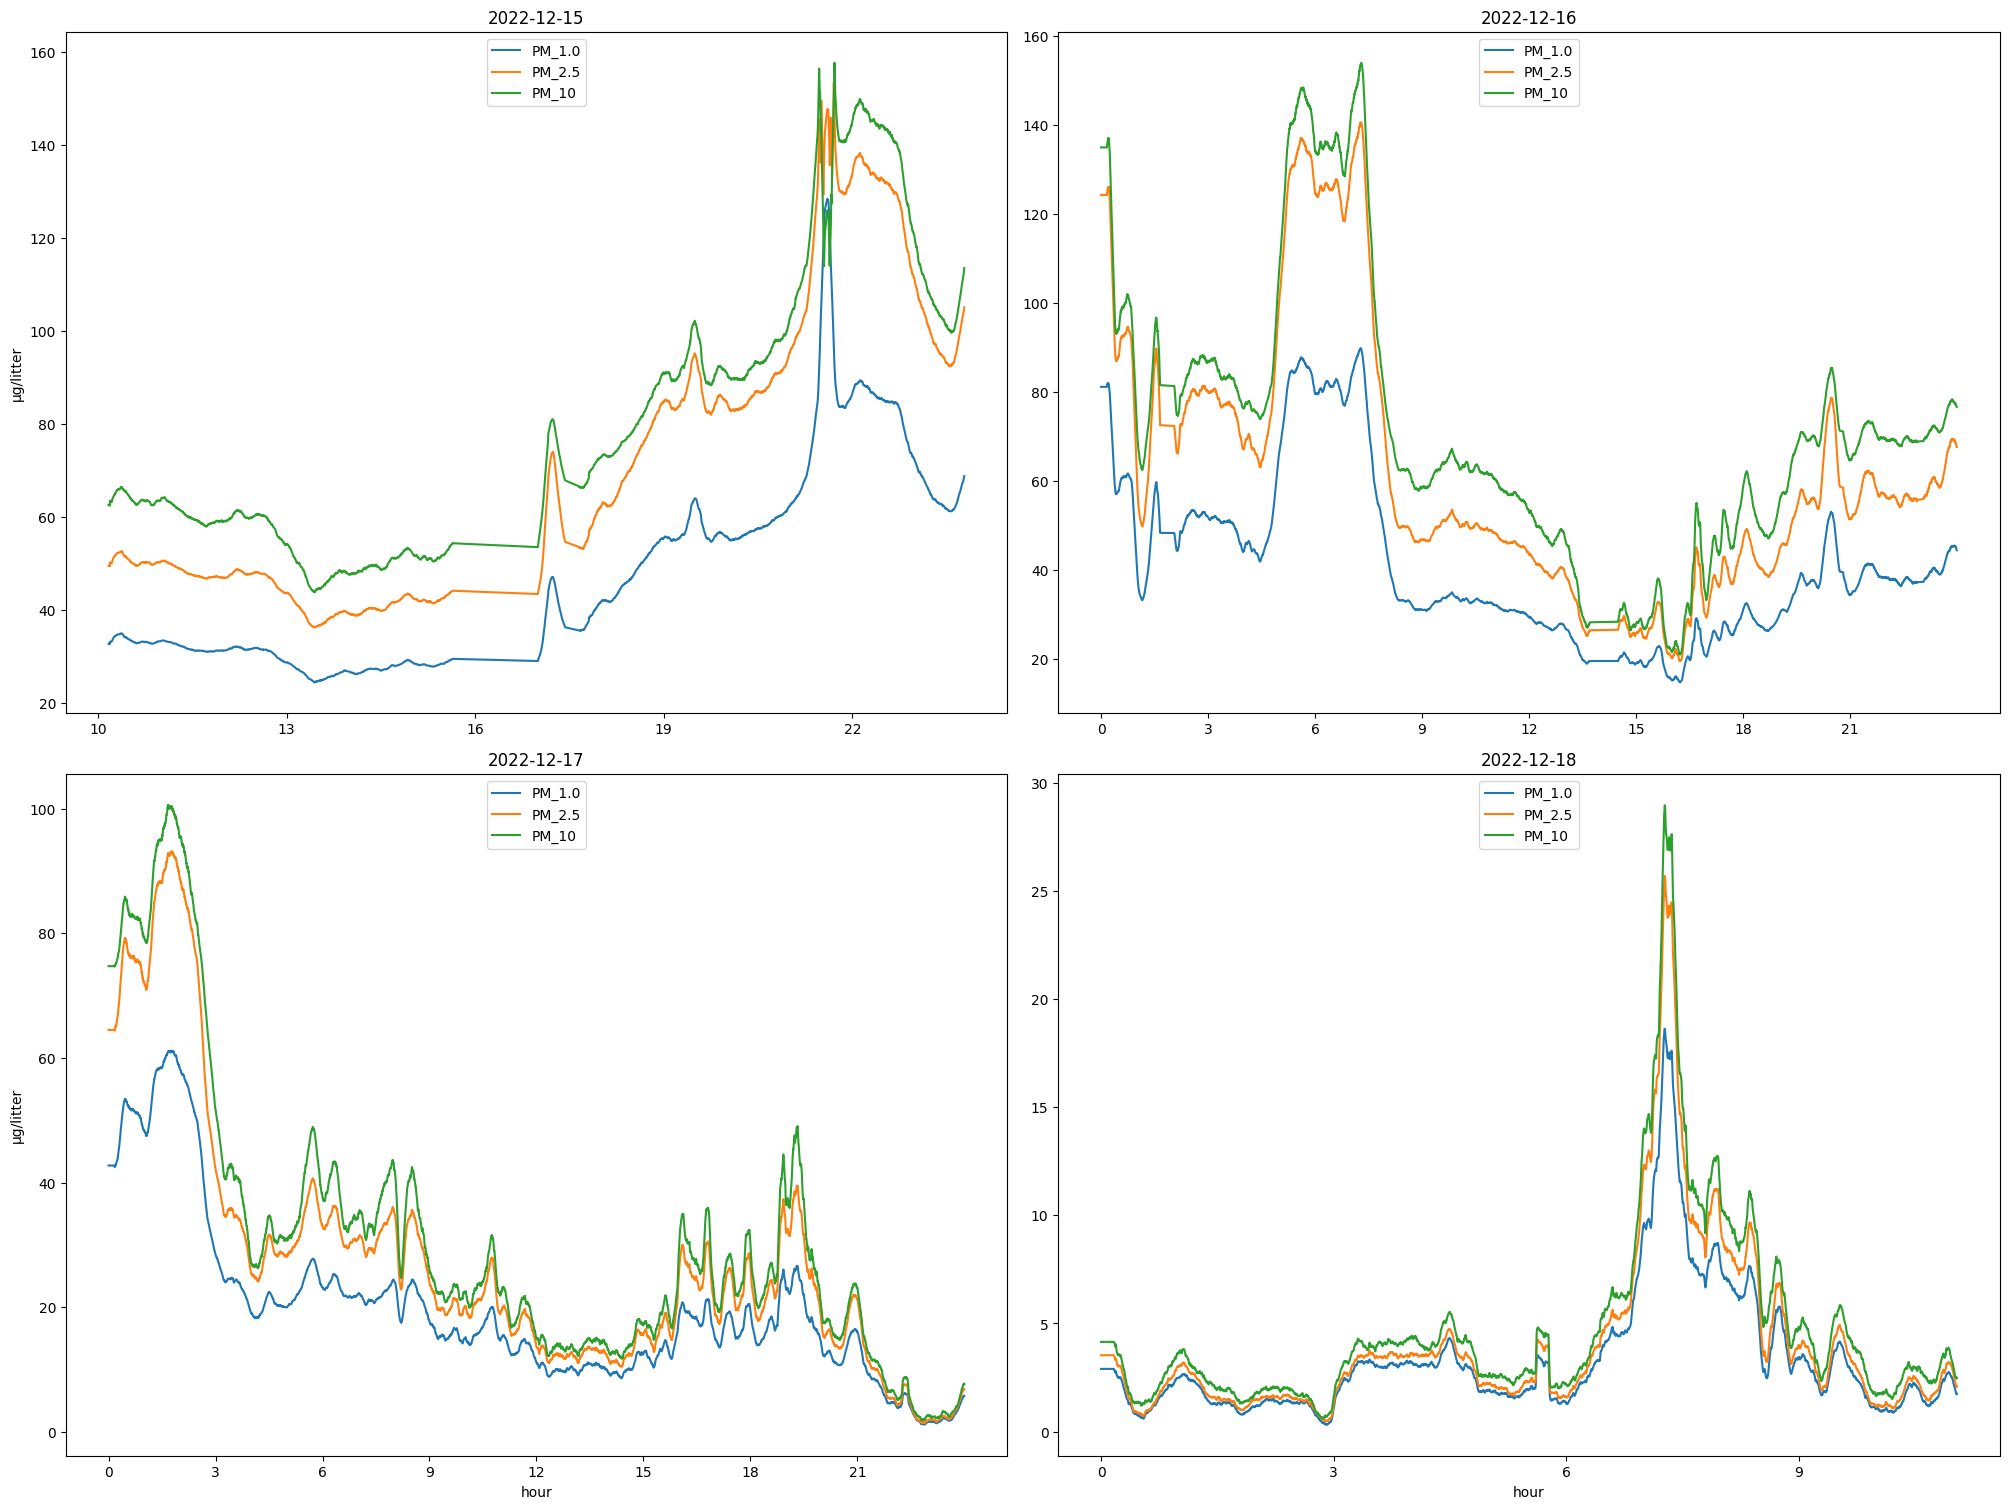

In [22]:

node_2 = [i for i in os.listdir('./node_2/')]
node_2_path = currPath / "node_2"

fig, ax = plt.subplots(2,2,figsize=(20,15))
countRow = 0
countCol = 0
for i in node_2:
    if i != 'combined.csv':
        f = pd.read_csv(node_2_path/ i)
        f['Datetime'] = pd.to_datetime(f['Datetime'])

        f.sort_values(by='Datetime', inplace=True)
        x = f['Datetime']

        f['PM_1.0_MA'] = f['PM_1.0'].rolling(window=60).mean()
        f['PM_1.0_MA'] = f['PM_1.0_MA'].fillna(f['PM_1.0_MA'][59])
        pm1 = f['PM_1.0_MA']

        f['PM_2.5_MA'] = f['PM_2.5'].rolling(window=60).mean()
        f['PM_2.5_MA'] = f['PM_2.5_MA'].fillna(f['PM_2.5_MA'][59])
        pm2_5 = f['PM_2.5_MA']

        f['PM_10_MA'] = f['PM_10'].rolling(window=60).mean()
        f['PM_10_MA'] = f['PM_10_MA'].fillna(f['PM_10_MA'][59])
        pm10 = f['PM_10_MA']

        ax[countRow,countCol].plot(x,pm1, label='PM_1.0')
        ax[countRow,countCol].plot(x,pm2_5, label='PM_2.5')
        ax[countRow,countCol].plot(x,pm10, label='PM_10')
        ax[countRow,countCol].legend(loc='upper center')
        ax[countRow,countCol].set_title(str(f['Datetime'][0].date()))

        x_axis = pd.date_range(f['Datetime'].min(), f['Datetime'].max(), freq='3H')
        ax[countRow,countCol].set_xticks(x_axis, labels=[str(i.hour) for i in x_axis])
        
        
        

    if countCol== 1:
        countCol = 0
        countRow+=1
    else:
        countCol += 1

fig.tight_layout()
plt.setp(ax[:,0], ylabel = 'µg/litter')
plt.setp(ax[-1,:], xlabel = 'hour')
plt.savefig("./graphs/node_2.png")